# Charge 3: Téléportation quantique

Dans ce notebook, nous allons effectuer une téléportation quantique entre 2 qubits d'un ordinateur quantique.

Nous allons utiliser le protocole démontré en classe selon lequel Alice peut transférer un état quelconque $|\psi\rangle$ à Bob, pouvant être séparé par des milliers de kilomètres, ou dans le cas ici d'environ 1 cm entre 2 qubits supraconducteurs. 

In [1]:
# On importe les librairies
import numpy as np
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# On utilise notre compte IBMQ.
provider = IBMQ.load_account()
# Charger notre compte IBM Q du Hub pour avoir accès à tous les ordis quantiques.
# Optionel, pour les membres du Hub ayant complété le formulaire seulement.
provider = IBMQ.get_provider(hub='ibm-q-sherbrooke', group='etudiants-udes', project='phq637-phy737')

/Users/eliegenois/anaconda3/envs/qutip-env/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


### On construit le circuit de téléportation quantique

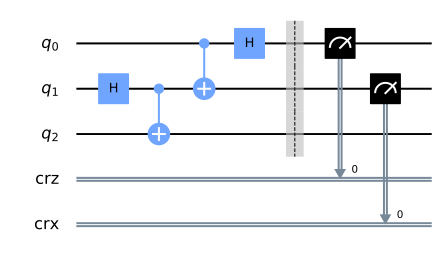

In [3]:
qr = QuantumRegister(3, name="q")
crz = ClassicalRegister(1, name="crz")
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

# Étape 1) Créer une paire de Bell
qc.h(1)
qc.cx(1, 2)

# Étape 2) Effectuer les portes d'Alice
qc.cx(0, 1)
qc.h(0)

# Étape 3) Alice mesure les 2 qubits (obtient x et y) et 'envoie' le résultat à Bob
qc.barrier()
qc.measure(0,0)
qc.measure(1,1)

qc.draw(output='mpl')

#### Étape 4) Bob applique les portes X et Z selon les résultats de mesure (transmis classsiquement par Alice)
Ici (z,x) = 00, 01, 10, ou 11.
- 00 -> Fait rien
- 01 -> Applique X
- 10 -> Applique Z
- 11 -> Applique ZX

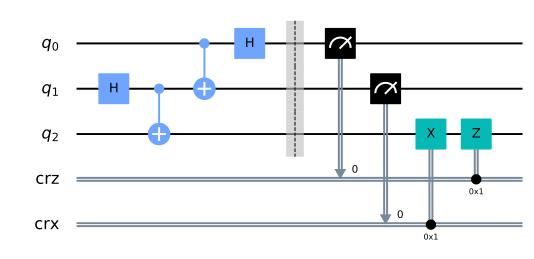

In [4]:
# Étape 4) Bob applique les portes X et Z selon les résultats de mesure
qc.x(2).c_if(crx, 1)
qc.z(2).c_if(crz, 1)
qc.draw(output='mpl')

### Voilà, c'est tout: Alice a téléporté son état à Bob qui se trouve à des milliers de $\mu$m

# Téléportons un qubit sur un ordinateur quantique d'IBM

On effectue une rotation de 0.23 rad autour de X à partir de l'état |0>


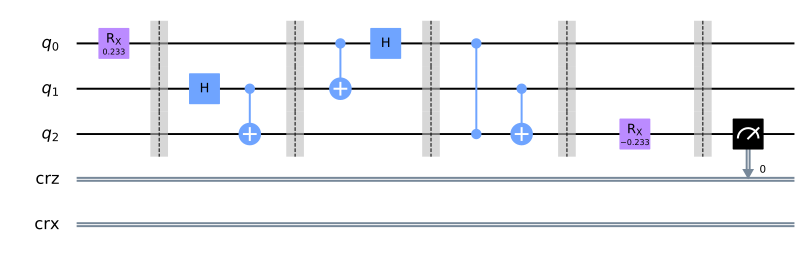

In [20]:
qr = QuantumRegister(3, name="q")
c = ClassicalRegister(1)
qc = QuantumCircuit(qr, crz, crx)

# Étape 0) On crée un état aléatoire que l'on veut téléporter
# Ici, une rotation selon X d'un angle aléatoire entre 0 et 2pi.
angle = np.random.rand(1)[0]*2*np.pi
print("On effectue une rotation de {:.2f} rad autour de X à partir de l'état |0>".format(angle))
qc.rx(angle, 0)
qc.barrier()

# Étape 1) Créer une paire de Bell
qc.h(1)
qc.cx(1, 2)
qc.barrier()

# Étape 2) Effectuer les portes d'Alice
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Étape 3) On effectue maintenant le principe de la mesure différée 
# pour laisser toutes les mesures à la fin.
qc.cz(0, 2)
qc.cx(1, 2)
qc.barrier()

# Étape 4) On défait l'initialization faite avec la rotation autour de X pour mesurer |0> en principe
qc.rx(-angle, 2)
qc.barrier()

# Étape 5) On mesure le qubit 2 auquel on s'intéresse pour voir 
# si l'on a bien téléporté notre état |psi> = Rx(angle)|0> -> |0>
qc.measure(2,0)

qc.draw(output='mpl')

In [13]:
# On utilise le "least-busy backend" de IBM et roule le circuit quantique sur cet appareil.
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))

In [14]:
print(backend)

ibmq_manhattan


#### Il s'agit du plus gros ordinateur quantique supraconducteur disponible construit jusqu'à maintenant, avec **65 qubits**.

In [21]:
job_exp = execute(qc, backend=backend, shots=8192)
qiskit.tools.monitor.job_monitor(job_exp)

Job Status: job has successfully run


{'0 0': 7590, '0 1': 602}


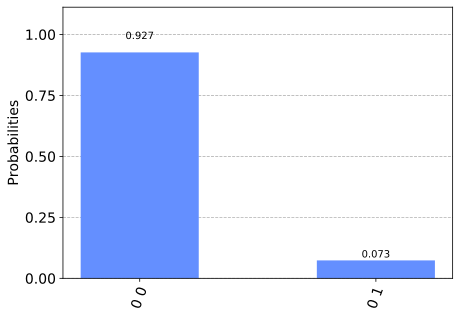

In [22]:
# On extrait les résultats et on les illustre
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

Contrairement au cas parfait, on a des erreurs où l'on mesure |1> au lieu de l'état attendu |0>.
Cela peut se produire à plusieurs endroits dans un vrai ordinateur quantique, par exemple au niveau des preparations, portes logiques, mesures, etc.

In [29]:
error_rate_percent = sum([exp_measurement_result[result] for result in exp_measurement_result.keys() if result=='0 1']) \
                    * 100./ sum(list(exp_measurement_result.values()))
print("The experimental error rate : ", error_rate_percent, "%")

The experimental error rate :  7.3486328125 %


### On a téléporté un qubit sur un ordinateur quantique ~93% du temps!